# Numerical project in Python

We will consider the problem of finding the static equilibrium of a chain formed by rigid bars in 2D.
This will be found via an optimization problem with equality constraints.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

## Question 2

Python function that given $z$ as an imput, returns :

$$
c(z) = (c_1 (z) , \ldots , c_{N+1} (z) ) = (l_{i}(x, y)^{2}-L^{2} = \bigl(  (x_{i}-x_{i-1})^{2}+(y_{i}-y_{i-1})^{2}-L^{2} \, , \, i \in [ 1 , \ldots , N+1 ] \bigr)
$$

In [4]:
def c(z):
    N=int(np.size(z)/2)

    c=np.zeros(N+1)
    c[0] = z[0]**2+z[N]**2 - L**2
    c[N] = (a-z[N-1])**2+(b-z[2*N-1])**2 - L**2
    for i in range(1,N):
        c[i]=(z[i]-z[i-1])**2+(z[i+N]-z[i-1+N])**2 - L**2
   
    return c

## Question 3

Python function that given $z$ as an imput, return $\sum_i y_i$.

To do so, we compute a $e = (0 , \ldots , 0 , 1 , \ldots , 1)$ $2n$-array, and we comput the dot product of $e . z$ .

In [5]:
def e(z):
    N=int(np.size(z)/2)
    e=np.zeros(2*N)
    e[N:2*N:1]=np.ones(N)
    return e

In [6]:
def cost(z):
    return np.dot(e(z), z)

## Question 4

Python function that returns the lagrangian of the systeme, given $z$ and $\lambda$ as an imput.

To do so we write the Lagrangian as :

$$
\mathcal{L}(z, \lambda)=e^Tz+\lambda^{\top} c(z)
$$

In [7]:
def lag(z,labda):
    ee=e(z)
    return cost(z) + np.dot(labda,c(z))

## Question 5

Python function, that given $z$, $\lambda$ as an imput, yields $\nabla_z \mathcal{L}(z, \lambda)$.

As shown in the report : 
$$
\nabla_{z} \mathcal{L}(z, \lambda)=e+\nabla_{z}^{\top} c(z) \lambda \in \mathbf{R}^{2 N}
$$

where the gradient matrix of c (transpose of the Jacobian matrix) is :
$$
\nabla_{z}^{\top} c(z)= 2\begin{bmatrix}
x_1 & -(x_2 - x_1) & 0 & \cdots & 0 \\
0 & (x_2 - x_1) & -(x_3 - x_2) & \cdots & 0 \\
\\
\vdots & & \ddots & \ddots & \vdots \\
& & & & 0\\
0 & \cdots & 0 & (x_N - x_{N-1}) & -(x_N - a)\\
\hline y_1 & -(y_2 - y_1) & 0 & \cdots & 0 \\
0 & (y_2 - y_1) & -(y_3 - y_2) & \cdots & 0 \\
\\
\vdots & & \ddots & \ddots & \vdots \\
& & & & 0\\
0 & \cdots & 0 & (y_N - y_{N-1}) & -(y_N - a)\\
\end{bmatrix} \in \mathbf{R}^{2 N \times N+1}
$$

First lets compute this gradient matrix :

In [8]:
def gradc(z):
    N=int(np.size(z)/2)
    grad_c=np.zeros((2*N, N+1))
    
    grad_c[0,0] = z[0]
    grad_c[N,0] = z[N]
    grad_c[N-1,N] = z[N-1]-a
    grad_c[2*N-1,N] = z[2*N-1]-b
     
    for j in range(1,N):
        temp = z[j]-z[j-1]
        grad_c[j-1,j] = -temp
        grad_c[j,j] = temp
        temp = z[N+j]-z[N+j-1]
        grad_c[N+j-1,j] = -temp
        grad_c[N+j,j] = temp
    return 2*grad_c

We deduce the gradient of the Lagrangian by the quick vectorial calculation above

In [9]:
def gradlag(z,labda):
    ee =e(z)
    grad_c = gradc(z)
    return ee + np.dot(grad_c,labda)

This function also check that the derivatives are correct, by checking that :
$$
\frac{\left\|c(z+\delta)-c(z)-\nabla_{z} c(z) \delta\right\|}{\|\delta\|} \leq 0.01
$$

for a small random perturbation $\delta$, for a given $z$.

In [10]:
def checkcjac(z,delta):
    cpert = c(z+delta)
    cc = c(z)
    cjac_delta = np.dot(np.transpose(gradc(z)), delta)
    n1 = np.linalg.norm(cpert - cc - cjac_delta)
    n2 = np.linalg.norm(delta)
    return n1/n2

In [11]:
N=5
L = 0.25
a,b = 1,-.1
z = np.zeros(2*N)
z[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
z[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in z[0:N]]
delta = 1e-3*(np.random.random(2*N)-0.5)

In [12]:
checkcjac(z,delta)

0.0010543274459379316

## Question 6

Python function, that given $z$, $\lambda$ as an imput, yields $\nabla_{zz} \mathcal{L} (z, \lambda)$.

As shown in the report, the exact calculation of the Hessian of the Lagrangian give us :

$$
\nabla_{zz} \mathcal{L} (z, \lambda) = \begin{bmatrix} A & 0 \\ 0 & A \end{bmatrix}
$$

where :

$$
A =
    2 \begin{pmatrix}
    \lambda_1+\lambda_2 & -\lambda_2 & & & (0)\\
    -\lambda_2 & \lambda_2+\lambda_3 & -\lambda_3 & \\
     & \ddots & \ddots & \ddots \\
      &  & \ddots & \ddots & -\lambda_n \\
     (0) & & & -\lambda_n & \lambda_n+\lambda_{n+1}
    \end{pmatrix}
$$

In [41]:
def hesslag(z, labda):
    N=int(np.size(z)/2)
    A=np.zeros((N, N))
    zero=np.zeros((N, N))
    for i in range(N):
        A[i,i] = labda[i] + labda[i+1]
    for i in range(1,N):
        temp = -labda[i]
        A[i-1,i] = temp
        A[i,i-1] = temp
    
    hess=np.zeros((2*N,2*N))
    hess[0:N , 0:N] = 2*A
    hess[0:N , N:2*N] = zero
    hess[N:2*N , 0:N] = zero
    hess[N:2*N , N:2*N] = 2*A
    return hess

We also check that the double derivatives are correct, by checking that :

$$
\frac{\left\| \mathcal{L}(z+\delta)- \mathcal{L}(z) - \nabla_{z} \mathcal{L}(z) \delta - \delta^{T} \nabla_{zz} \mathcal{L}(z,\lambda) \delta \right\|}{\left\|\delta\ \right\|^2} \leq 0.01
$$

for a small random perturbation $\delta$, and for a given $z$ and $\lambda$.

In [42]:
def checkhess(z,delta, labda):
    lagpert = lag(z+delta, labda)
    lagg = lag(z, labda)
    gradlag_delta = np.dot(gradlag(z, labda), delta)
    hesslag_delta = (np.transpose(delta)).dot(hesslag(z, labda).dot(delta))
    
    n1 = np.linalg.norm(lagpert - lagg - gradlag_delta - hesslag_delta)
    n2 = np.linalg.norm(delta)
    return n1/(n2**2)

In [43]:
N=5
L = 0.25
a,b = 1,-.1
z = np.zeros(2*N)
z[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
z[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in z[0:N]]
delta = 1e-3*np.random.random(2*N)
labda = 0.1*np.ones(N+1)

In [46]:
checkhess(z, delta, labda)


0.09438945438792627

## Question 7

The problem is not convexe because even if the cost function is convexe, the admissble set is not. Indeed, the admissible set is defined by $c(z) = 0$.

For instance if we take $a = 0, b = \frac{L}{2}$, the minimum energie solution is of the form $ z = (x, y)$ (the chain is hanging down between the two fixations), and the solution $z = (x, -y)$ is also admisible, $c(x,y) = c(x -y)$ (it is the maximum energie solution, the chain is attracted by the top). But the mean vector of this two admissible solutions is $z = (x, 0)$ which is not admisble because it correspond to the a case where the chain is horizontal atached between the point (0,0) and (0, L/2), but its lenght is $L$, which is impossible in a lenght of $\frac{L}{2}$.

This prove taht the problem is non-convex.

## Question 8

Now let's discuss about the qualification of the constraints. A necessary condition for the constraints to be qualified is to say that the Jacobian matrix of the constrains is surjective. In our case the Jacobain matrix of the constraints c is the transpose of the matrix $\nabla^{T} c(z)$, which is to say the matrix 
$$
\nabla_{z} c(z) = 2 
\begin{bmatrix}
x_1 & 0  & \cdots & 0 & | & y_1 & 0  & \cdots & 0 \\
-(x_2 - x_1) & (x_2 - x_1) &  & \vdots & | & -(y_2 - y_1) & (y_2 - y_1) &  & \vdots\\
0 & -(x_3-x_2) & \ddots & 0 & | & 0 & -(y_3-y_2) & \ddots & 0 \\
\vdots & \vdots & \ddots & (x_N-x_{N-1}) & | &\vdots & \vdots & \ddots & (y_N-y_{N-1}) \\
0 & 0 & \cdots & -(x_N-a) & | & 0 & 0 & \cdots & -(y_N-a)\\
\end{bmatrix}\in \mathbf{R}^{2 N \times N+1}
$$

As shown in the report, the rank of this matrix is of rank $N+1$, and so it is surjective.

Thus we know that we can apply the KKT conditions to this problem.

## Question 9

As shown in the report, the condition is :

$$
a^2 + b^2 \le ((N+1)L)^2
$$

## Question 10

Let's solve this KKT optimality conditions problem with the Newton's method.

Let $F(\xi)=0$ represent the above non-linear system of equation, with $\xi=(z, \lambda)$ where :
$F(\xi): \mathbf{R}^{2 N+N+1} \rightarrow \mathbf{R}^{2 N+N+1}, \quad F(\xi)=\left[\begin{array}{c}e+\nabla_{z}^{\top} c(z) \lambda \\ c(z)\end{array}\right]$.

So
$$
\nabla_{\xi} F(\xi) \in \mathbf{R}^{2 N+N+1 \times 2 N+N+1}, \quad \nabla_{\xi} F(\xi)=\left[\begin{array}{cc}
\nabla_{z}\left(\nabla_{z}^{\top} c(z) \lambda\right) & \nabla_{z}^{\top} c(z) \\
\nabla_{z} c(z) & 0
\end{array}\right]
$$

where one could verify that
$$
\nabla_{z}\left(\nabla_{z}^{\top} c(z) \lambda\right)=\left[\nabla_{x_{j}} \sum_{k=1}^{N+1} \nabla_{x_{i}} c_{k}(x, y) \lambda_{k}\right]_{i j} \in \mathbf{R}^{2 N \times 2 N}=\nabla_{z z} \mathcal{L}(z, \lambda)
$$

So  we can finally right that : 
$$
 \nabla_{\xi} F(\xi)=\left[\begin{array}{cc}
\nabla_{z z} \mathcal{L}(z, \lambda) & \nabla_{z}^{\top} c(z) \\
\nabla_{z} c(z) & 0
\end{array}\right]
$$

Let's first wright the Python function, that given $z$, $\lambda$ as an imput, yields $\nabla_{\xi} F(\xi)$, by reusing the previous functions.

In [17]:
def Fjac(z, labda):
    N=int(np.size(z)/2)

    hess_lag = hesslag(z, labda)
    grad_c = gradc(z)
    
    Fjac=np.zeros((3*N + 1, 3*N + 1))
    Fjac[:2*N , :2*N] = hess_lag
    Fjac[:2*N , 2*N:] = grad_c
    Fjac[2*N: , :2*N] = np.transpose(grad_c)

    return Fjac

In [47]:
Fjac(z, labda)

array([[ 0.4       , -0.2       ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.33333333, -0.33333333,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.2       ,  0.4       , -0.2       ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.33333333, -0.33333333,  0.        ,  0.        ,
         0.        ],
       [ 0.        , -0.2       ,  0.4       , -0.2       ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.33333333, -0.33333333,  0.        ,
         0.        ],
       [ 0.        ,  0.        , -0.2       ,  0.4       , -0.2       ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.33333333, -0.33333333,
         0.        ],
       [ 0.        ,  0.        ,  0

Let's assume that the Jacobian matrix is invertible. We can now define a Newton's method algorithms that compute the Nexton's method for a given initial $\xi^{0}$, a stopping error criterion $\epsilon$, and a maximum number of iterations $M$.

To do so, we'll need a function that yeilds the value of $F(\xi)$ for a given $\xi \in \mathbb{R}^{2N + N + 1}$

In [18]:
def bigF(z, labda):
    F = np.zeros(3*N + 1)
    grad_lag = gradlag(z, labda)
    cc = c(z)
    F[0:2*N] = grad_lag
    F[2*N:3*N + 1] = cc
    return F

In [97]:
def NewtonF(z, labda, eps = 1e-3, M = 100, alpha=1):
    k=0
    xi = np.zeros(3*N + 1)
    xi[:2*N] = z
    xi[2*N:] = labda
    F_xi = bigF(xi[:2*N], xi[2*N:])
    F_jac = Fjac(xi[:2*N], xi[2*N:])
    n=np.linalg.norm(F_xi)
    
    while(n>eps and k < M):
    
        d = np.linalg.solve( F_jac , -F_xi)
        xi = xi + alpha*d
        F_xi = bigF(xi[:2*N], xi[2*N:])
        F_jac = Fjac(xi[:2*N], xi[2*N:])
        n=np.linalg.norm(F_xi)
        k += 1
        
    return n, xi[:2*N], xi[2*N:]

We need a routine to plot the solution of the Newton's method in order to see if the result correspond to the real physicla solution.

In [71]:
def plot(z,a,b):
    N = int(np.size(z)/2)
    x = np.zeros(N+2)
    x[0] = 0
    x[N+1] = a
    x[1:N+1] = z[:N]
    y = np.zeros(N+2)
    y[0] = 0
    y[N+1] = b
    y[1:N+1] = z[N:]
    plt.plot(x, y)
    plt.grid()
    plt.show()

## Question 11

We are now able to plot  solution, convergence, type of stationary points, and relevant metrics for the tarting settings: 

In [122]:
N=5
L = 0.25
a,b = 1,-.1
z = np.zeros(2*N)
z[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
z[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in z[0:N]]
labda = 0.1*np.random.random(N+1)

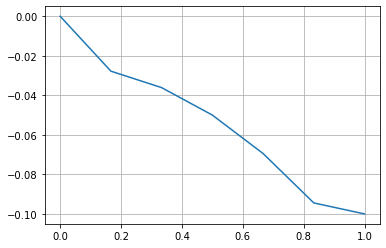

In [81]:
plot(z, a, b)

In [123]:
norm, z_etoile, labda_etoile = NewtonF(z, labda, 0.02 , 1000) 

norm

0.008166471160776824

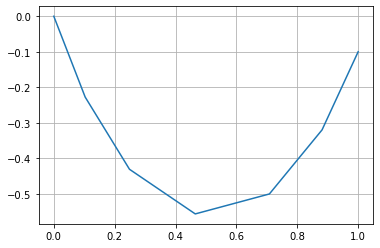

In [124]:
plot(z_etoile, a, b)

It is also possible to add a backtracking strategy in the Newton's method, by adding a parameter $\alpha$ in the
list of arguments of the function.

In [125]:
norm, z_etoile, labda_etoile = NewtonF_back(z, labda, 0.02 , 100, 0.5) 

norm
plot(z_etoile, a, b)

0.017779626185643504

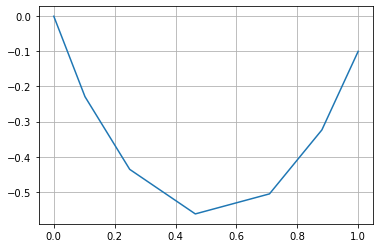

In [126]:
plot(z_etoile, a, b)

## Question 12

Now let's explore differents values for sevaral possiblilities of N, L, and initial conditions $\xi_0$.

Let's start with the very particular case where the chain is completely strechted, i.e. a case where $ a^2 + b^2 = (N+1)^2 L^2$.

In [173]:
N=100
L = 0.25
a,b = (N+1)*L - 0.01,0
z = np.zeros(2*N)
z[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
z[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in z[0:N]]
labda = 0.1*np.random.random(N+1)

In [174]:
norm, z_etoile, labda_etoile = NewtonF_back(z, labda, 0.02 , 10000, 0.5) 

norm

nan

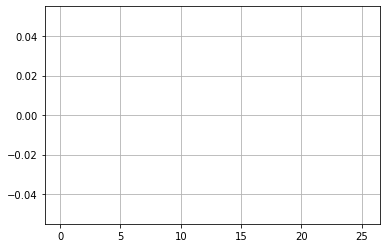

In [175]:
plot(z_etoile, a, b)

We can see that the chain is not repsectong the equality constraints at al, and that the value of the $\mathcal{F}$ function is very far from $0$. This rxemple show that in this particular case, the contrains are not qualified in this extreme situations.

Let's now see what appends when $N$ gets bigger in the regular situation that we stygied before :

In [176]:
N=500
L = 0.25
a,b = 1,-.1
z = np.zeros(2*N)
z[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
z[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in z[0:N]]
labda = 0.1*np.random.random(N+1)

In [180]:
norm, z_etoile, labda_etoile = NewtonF_back(z, labda, 0.02 , 1000, 0.5) 

norm

14.703261107399314

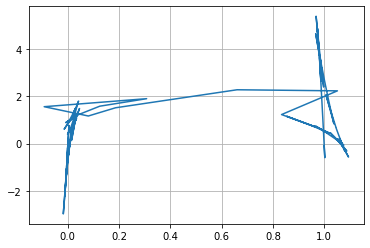

In [181]:
plot(z_etoile, a, b)